In [2]:
import os 

import tensorflow as tf
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
model_version = '7seg2912'

BASELINE = '../sd-card/config/dig-class11_1600_s2.tflite'

MODEL_FILE_PATH = f'../models/{model_version}.keras'
TFLITE_FILE_PATH = f'../models/{model_version}.tflite'
TFLITE_Q_FILE_PATH = f'../models/{model_version}q.tflite'

In [5]:
def yield_image() -> tuple:
    digits_dir = '../training/digits_resized'
    
    for image_path in os.listdir(digits_dir):
        image_in = Image.open(os.path.join(digits_dir, image_path))
        test_image = np.array(image_in, dtype="float32")
        img = np.reshape(test_image, [1, 32, 20, 3])
        
        correct_digit = int(image_path.split('_')[0])
        
        yield correct_digit, img

# AI-on-the-edge-device standard model

In [4]:
# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(BASELINE)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
tf_lite_res = []

for correct_digit, img in yield_image():
    interpreter.set_tensor(input_details[0]['index'], img)
    tflite_times = interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred_digit = output_data.argmax(axis=-1)[0]
    
    tf_lite_res.append(int(pred_digit) == int(correct_digit))

In [6]:
baseline_arr = np.array(tf_lite_res)

In [7]:
baseline_accuracy = len(baseline_arr[baseline_arr == True]) / len(baseline_arr)
baseline_accuracy

0.3140797994568623

# Standard model

In [8]:
model = tf.keras.models.load_model(MODEL_FILE_PATH)

In [9]:
correct_res = []

for correct_digit, img in yield_image():
    pred_digit = np.argmax(model.predict(img, verbose=0))
    correct_res.append(int(pred_digit) == int(correct_digit))

In [10]:
std_arr = np.array(correct_res)

In [11]:
standard_accuracy = len(std_arr[std_arr == True]) / len(std_arr)
standard_accuracy

0.9975976603300606

# TFLite model

In [12]:
# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [13]:
tf_lite_res = []

for correct_digit, img in yield_image():
    interpreter.set_tensor(input_details[0]['index'], img)
    tflite_times = interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred_digit = output_data.argmax(axis=-1)[0]
    
    tf_lite_res.append(int(pred_digit) == int(correct_digit))

In [14]:
tflite_arr = np.array(tf_lite_res)

In [15]:
tflite_accuracy = len(tflite_arr[tflite_arr == True]) / len(tflite_arr)
tflite_accuracy

0.9975976603300606

# TLITE quantized model

In [16]:
# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(TFLITE_Q_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [17]:
tf_lite_q_res = []

for correct_digit, img in yield_image():
    interpreter.set_tensor(input_details[0]['index'], img)
    tflite_times = interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred_digit = output_data.argmax(axis=-1)[0]
    
    tf_lite_q_res.append(int(pred_digit) == int(correct_digit))

In [18]:
tflite_q_arr = np.array(tf_lite_q_res)

In [19]:
q_accuracy = len(tflite_arr[tflite_arr == True]) / len(tflite_arr)
q_accuracy

0.9975976603300606

In [20]:
len(tflite_arr[tflite_arr == False])

23

# Plots

Text(0, 0.5, 'accuracy')

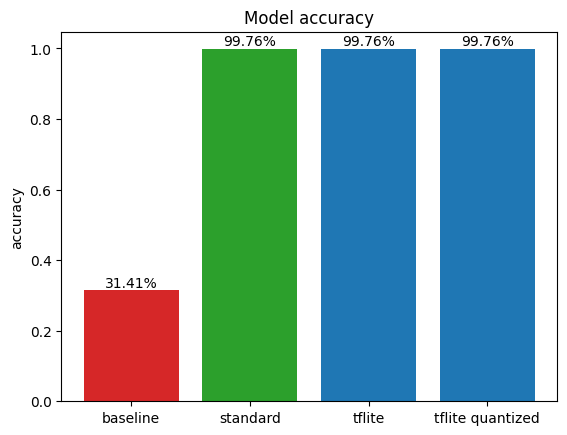

In [28]:
import matplotlib.pyplot as plt 

def add_labels(x, y):
    for i, y_i in enumerate(y):
        y_display = np.round(y_i * 100, 2)
        
        plt.text(i, y_i + 0.01, f'{y_display}%', ha = 'center')

models = ['baseline', 'standard', 'tflite', 'tflite quantized']
accuracies = [baseline_accuracy, standard_accuracy, tflite_accuracy, q_accuracy]

bar_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:blue']

plt.title('Model accuracy')
plt.bar(models, accuracies, color=bar_colors)

add_labels(models, accuracies)

plt.ylabel('accuracy')

## Confusion Matrix
### Baseline

In [29]:
interpreter = tf.lite.Interpreter(BASELINE)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tf_lite_true = []
tf_lite_pred = []

for correct_digit, img in yield_image():
    interpreter.set_tensor(input_details[0]['index'], img)
    tflite_times = interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    pred_digit = output_data.argmax(axis=-1)[0]

    tf_lite_true.append(correct_digit)
    tf_lite_pred.append(pred_digit)

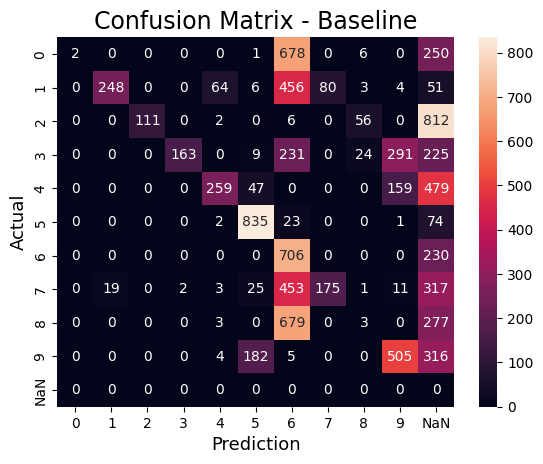

In [30]:
cm = confusion_matrix(tf_lite_true, tf_lite_pred)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['0','1', '2', '3', '4', '5', '6', '7', '8', '9', 'NaN'],
            yticklabels=['0','1', '2', '3', '4', '5', '6', '7', '8', '9', 'NaN'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix - Baseline',fontsize=17)
plt.show()

### Trained model

In [39]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tf_lite_true = []
tf_lite_pred = []

for correct_digit, img in yield_image():
    interpreter.set_tensor(input_details[0]['index'], img)
    tflite_times = interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    pred_digit = output_data.argmax(axis=-1)[0]

    tf_lite_true.append(correct_digit)
    tf_lite_pred.append(pred_digit)

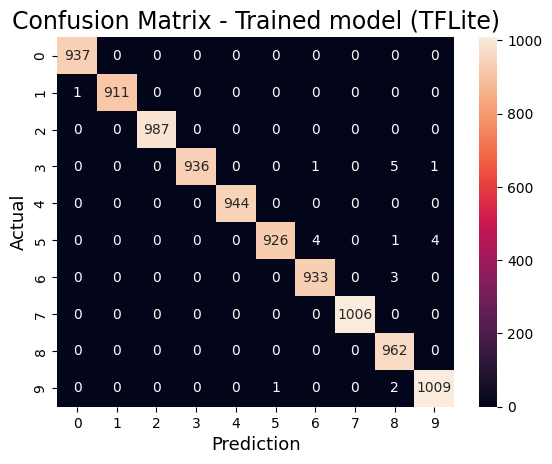

In [40]:
cm = confusion_matrix(tf_lite_true, tf_lite_pred)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['0','1', '2', '3', '4', '5', '6', '7', '8', '9'],
            yticklabels=['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix - Trained model (TFLite)',fontsize=17)
plt.show()